<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
df.sort_index(inplace=True)
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Проверка на наличие пустых значений

In [3]:
df.isna().sum()

num_orders    0
dtype: int64

## Анализ

Ресемплирование

In [4]:
resampled_data = df.resample('1H').sum()
resampled_data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Построение скользящего среднего

In [5]:
resampled_data['rolling'] = resampled_data.rolling(20).mean()
resampled_data.dropna(inplace=True)
resampled_data

,num_orders,rolling
datetime,,
2018-03-01 19:00:00,45,53.30
2018-03-01 20:00:00,61,50.15
2018-03-01 21:00:00,66,49.20
2018-03-01 22:00:00,113,51.30
2018-03-01 23:00:00,58,50.90
...,...,...
2018-08-31 19:00:00,136,163.85
2018-08-31 20:00:00,154,157.75
2018-08-31 21:00:00,159,156.00


Построение графика временного ряда и скользящего среднего

<AxesSubplot:xlabel='datetime'>

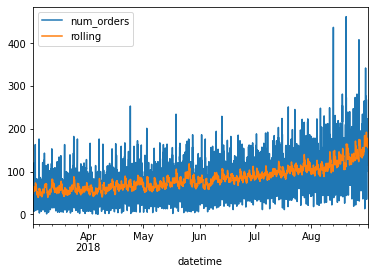

In [6]:
resampled_data.plot()

Добавил несколько графиков на коротком периоде

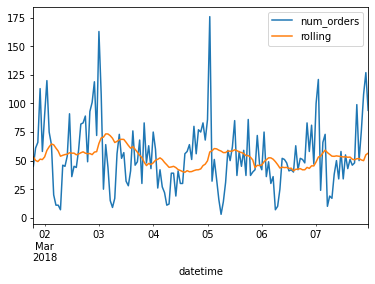

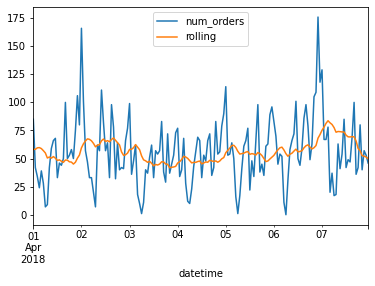

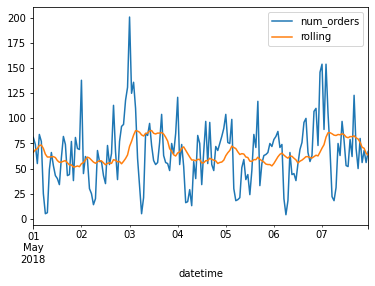

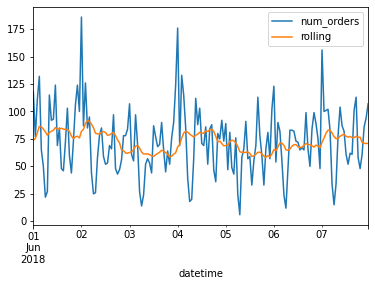

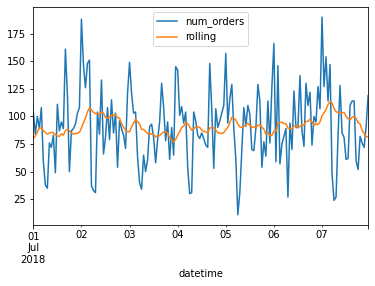

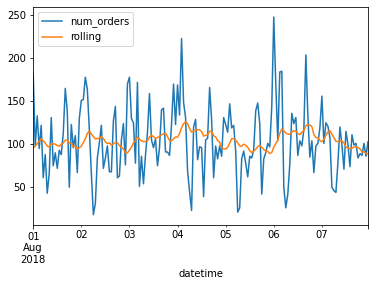

In [7]:
for i in ['03', '04', '05', '06', '07', '08']:
    resampled_data['2018-'+i+'-01':'2018-'+i+'-07'].plot()

Построение стационарного ряда

In [8]:
resampled_data['static'] = resampled_data['num_orders'] - resampled_data['num_orders'].shift()
resampled_data.dropna(inplace=True)
resampled_data

,num_orders,rolling,static
datetime,,,
2018-03-01 20:00:00,61,50.15,16.0
2018-03-01 21:00:00,66,49.20,5.0
2018-03-01 22:00:00,113,51.30,47.0
2018-03-01 23:00:00,58,50.90,-55.0
2018-03-02 00:00:00,90,53.25,32.0
...,...,...,...
2018-08-31 19:00:00,136,163.85,-71.0
2018-08-31 20:00:00,154,157.75,18.0
2018-08-31 21:00:00,159,156.00,5.0


In [9]:
resampled_data

,num_orders,rolling,static
datetime,,,
2018-03-01 20:00:00,61,50.15,16.0
2018-03-01 21:00:00,66,49.20,5.0
2018-03-01 22:00:00,113,51.30,47.0
2018-03-01 23:00:00,58,50.90,-55.0
2018-03-02 00:00:00,90,53.25,32.0
...,...,...,...
2018-08-31 19:00:00,136,163.85,-71.0
2018-08-31 20:00:00,154,157.75,18.0
2018-08-31 21:00:00,159,156.00,5.0


Построение ряда по дням

In [10]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
data.sort_index(inplace=True)
data = data.resample('1D').sum()
data

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259
...,...
2018-08-27,3936
2018-08-28,3357
2018-08-29,3762


In [11]:
data['rolling'] = data['num_orders'].rolling(7).mean()
data.dropna(inplace=True)

<AxesSubplot:xlabel='datetime'>

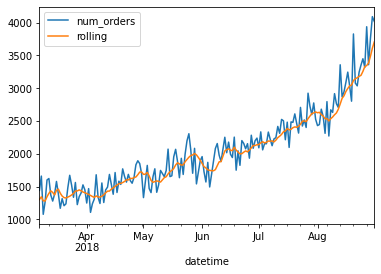

In [12]:
data.plot()

## Обучение

Построение признаков

In [13]:
data = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [14]:
def make_features(data, max_lag, rolling_mean_size):
    med = data.copy()
    #med['month'] = med.index.month
    #med['day'] = med.index.day
    med['dayofweek'] = med.index.dayofweek
    med['hour'] = data.index.hour
    
    
    for lag in range(1, max_lag + 1):
        med['lag_{}'.format(lag)] = med['num_orders'].shift(lag)

    med['rolling_mean'] = med['num_orders'].shift().rolling(rolling_mean_size).mean()
    return med.dropna()

In [15]:
result_data = make_features(data, 4, 4)
result_data

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,86.50
2018-03-01 05:00:00,6,3,5,43.0,66.0,71.0,85.0,66.25
2018-03-01 06:00:00,12,3,6,6.0,43.0,66.0,71.0,46.50
2018-03-01 07:00:00,15,3,7,12.0,6.0,43.0,66.0,31.75
2018-03-01 08:00:00,34,3,8,15.0,12.0,6.0,43.0,19.00
...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,4,19,207.0,217.0,197.0,116.0,184.25
2018-08-31 20:00:00,154,4,20,136.0,207.0,217.0,197.0,189.25
2018-08-31 21:00:00,159,4,21,154.0,136.0,207.0,217.0,178.50


In [16]:
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Подготовка метрики

In [17]:
def rmse(y_true, y_pred):
    value = mean_squared_error(y_true, y_pred)
    return np.sqrt(value)

In [18]:
rmse_scor = make_scorer(rmse, greater_is_better=False)

Обучение и валидация модели регрессии

In [19]:
min_score = 10**9
for max_lag in range(2, 15):
    for rolling_mean_size in range(2, 13):
        model = LinearRegression()
        dat = make_features(data, max_lag, rolling_mean_size)
        dat_train, dat_test = train_test_split(dat, shuffle=False, test_size=0.2)
        
        dat_valid, dat_test = train_test_split(dat_test, shuffle=False, test_size=0.5) #Выделение валидационной выборки
        
        train_features = dat_train.drop('num_orders', axis=1)
        train_target = dat_train['num_orders']
        
        valid_features = dat_valid.drop('num_orders', axis=1)
        valid_target = dat_valid['num_orders']
        model.fit(train_features, train_target)
        predictions = model.predict(valid_features)
        score = rmse(valid_target, predictions)
        if score < min_score:
            min_score = score
            best_lag = max_lag
            best_rolling_mean_size = rolling_mean_size
print('Лучший показатель rmse для регрессии:', min_score)
print('Наилучший шаг вычета рядов:', best_lag)
print('Наилучший интервал расчета скользящего среднего:', best_rolling_mean_size)

Лучший показатель rmse для регрессии: 41.500516309372266
Наилучший шаг вычета рядов: 14
Наилучший интервал расчета скользящего среднего: 2


Обучение и валидация модели CatBoostRegressor

In [20]:
min_score = 10**9
for max_lag in range(2, 7):
    for rolling_mean_size in range(2, 7):
        model = CatBoostRegressor(random_state=12345)
        dat = make_features(data, max_lag, rolling_mean_size)
        dat_train, dat_test = train_test_split(dat, shuffle=False, test_size=0.2) 
        
        dat_valid, dat_test = train_test_split(dat_test, shuffle=False, test_size=0.5) #Выделение валидационной выборки
        
        train_features = dat_train.drop('num_orders', axis=1)
        train_target = dat_train['num_orders']
        
        valid_features = dat_valid.drop('num_orders', axis=1)
        valid_target = dat_valid['num_orders']
        model.fit(train_features, train_target)
        predictions = model.predict(valid_features)
        score = rmse(valid_target, predictions)
        if score < min_score:
            min_score = score
            best_lag = max_lag
            best_rolling_mean_size = rolling_mean_size
print('Лучший показатель rmse для CatBoostRegressor:', min_score)
print('Наилучший шаг вычета рядов:', best_lag)
print('Наилучший интервал расчета скользящего среднего:', best_rolling_mean_size)

Learning rate set to 0.049974
0:	learn: 34.9309873	total: 48.2ms	remaining: 48.2s
1:	learn: 34.1827916	total: 49.7ms	remaining: 24.8s
2:	learn: 33.5848015	total: 51.2ms	remaining: 17s
3:	learn: 33.0016940	total: 52.6ms	remaining: 13.1s
4:	learn: 32.4595638	total: 54.2ms	remaining: 10.8s
5:	learn: 31.8704014	total: 55.9ms	remaining: 9.26s
6:	learn: 31.3433944	total: 57.6ms	remaining: 8.18s
7:	learn: 30.9342623	total: 58.9ms	remaining: 7.3s
8:	learn: 30.5015581	total: 60.2ms	remaining: 6.63s
9:	learn: 30.0583106	total: 61.6ms	remaining: 6.1s
10:	learn: 29.6937861	total: 62.9ms	remaining: 5.65s
11:	learn: 29.3367156	total: 64.2ms	remaining: 5.28s
12:	learn: 29.0226738	total: 65.4ms	remaining: 4.96s
13:	learn: 28.7767132	total: 66.6ms	remaining: 4.69s
14:	learn: 28.4901754	total: 67.9ms	remaining: 4.46s
15:	learn: 28.2101400	total: 69.2ms	remaining: 4.25s
16:	learn: 27.9913749	total: 70.5ms	remaining: 4.07s
17:	learn: 27.7638812	total: 71.6ms	remaining: 3.9s
18:	learn: 27.5506099	total: 72

Обучение и подбор лучший гиперпараметров модели RandomForestRegressor

In [21]:
min_score = 10**9
parametres = {'n_etimators':[100, 150, 200],
             'max_depth':[k for k in range(7, 15, 2)]
             }
count = 0
for max_lag in range(2, 7):
    for rolling_mean_size in range(2, 7):
        for estimators in [50, 100, 150]:
            for depth in [k for k in range(7, 14, 2)]:
                dat = make_features(data, max_lag, rolling_mean_size)
                dat_train, dat_test = train_test_split(dat, shuffle=False, test_size=0.2)
                
                dat_valid, dat_test = train_test_split(dat_test, shuffle=False, test_size=0.5)
                dat_train_features = dat_train.drop('num_orders', axis=1)
                dat_train_target = dat_train['num_orders']
                
                dat_valid_features = dat_valid.drop('num_orders', axis=1)
                dat_valid_target = dat_valid['num_orders']
                forest = RandomForestRegressor(random_state=12345, n_estimators=estimators, max_depth=depth)
                #grid = GridSearchCV(forest, param_grid=parametres, cv=1, scoring=rmse_scor)
                #grid.fit(dat_train_features, dat_train_target)
                #score = abs(grid.best_score_)
                forest.fit(dat_train_features, dat_train_target)
                pr = forest.predict(dat_valid_features)
                score = rmse(dat_valid_target, pr)
                count+=1
                print('Выполнено итераций: {} из 300'.format(count))
                if score < min_score:
                    #best_grid = grid
                    best_score = score
                    best_lag = max_lag
                    best_rolling_mean_size = rolling_mean_size
                    best_estimators = estimators
                    best_depth=depth
print('Наилучший показаетль rmse для случайного леса', best_score)
#print('Наилучшие гиперпараметры модели', best_grid.best_params)
print('Best estimators', best_estimators)
print('Best depth', best_depth)
print('Наилучший шаг вычета рядов', best_lag)
print('Наилучший интервал расчета скользящего среднего', best_rolling_mean_size)

Выполнено итераций: 1 из 300
Выполнено итераций: 2 из 300
Выполнено итераций: 3 из 300
Выполнено итераций: 4 из 300
Выполнено итераций: 5 из 300
Выполнено итераций: 6 из 300
Выполнено итераций: 7 из 300
Выполнено итераций: 8 из 300
Выполнено итераций: 9 из 300
Выполнено итераций: 10 из 300
Выполнено итераций: 11 из 300
Выполнено итераций: 12 из 300
Выполнено итераций: 13 из 300
Выполнено итераций: 14 из 300
Выполнено итераций: 15 из 300
Выполнено итераций: 16 из 300
Выполнено итераций: 17 из 300
Выполнено итераций: 18 из 300
Выполнено итераций: 19 из 300
Выполнено итераций: 20 из 300
Выполнено итераций: 21 из 300
Выполнено итераций: 22 из 300
Выполнено итераций: 23 из 300
Выполнено итераций: 24 из 300
Выполнено итераций: 25 из 300
Выполнено итераций: 26 из 300
Выполнено итераций: 27 из 300
Выполнено итераций: 28 из 300
Выполнено итераций: 29 из 300
Выполнено итераций: 30 из 300
Выполнено итераций: 31 из 300
Выполнено итераций: 32 из 300
Выполнено итераций: 33 из 300
Выполнено итераций:

## Тестирование

Проверка на тестовой выборке полученной модели линейной регрессии

In [22]:
data_regression = make_features(data, 14, 2)

dat_train, dat_test = train_test_split(data_regression, shuffle=False, test_size=0.1)
        
train_features_regression = dat_train.drop('num_orders', axis=1)
train_target_regression = dat_train['num_orders']
        
test_features_regression = dat_test.drop('num_orders', axis=1)
test_target_regression = dat_test['num_orders']

In [23]:
model_regr = LinearRegression()
model_regr.fit(train_features_regression, train_target_regression)
predictions_regr = model_regr.predict(test_features_regression)
regression_score_result = round(rmse(test_target_regression, predictions_regr), 2)
print("Показатель rmse для линейной регрессии на тестовой выборке", regression_score_result)

Показатель rmse для линейной регрессии на тестовой выборке 52.76


In [24]:
regression_comparing = pd.DataFrame(
    data={'предсказания':predictions_regr.copy(),
         'истинные_значения':test_target_regression.copy()
         }
)

<AxesSubplot:title={'center':'Сравнение за 2 дня'}, xlabel='datetime'>

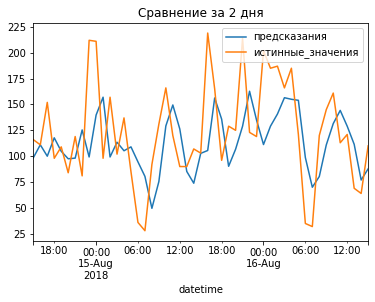

In [43]:
regression_comparing['2018-08-14 15:00:00':'2018-08-16 15:00:00'].plot(title='Сравнение за 2 дня')

<AxesSubplot:title={'center':'Сравнение за 3 дня с ресеймплингом'}, xlabel='datetime'>

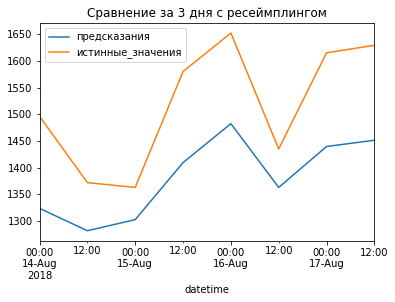

In [53]:
regression_comparing.resample('12H').sum()['2018-08-14':'2018-08-17'].plot(title='Сравнение за 3 дня с ресеймплингом')

In [27]:
regression_comparing

,предсказания,истинные_значения
datetime,,
2018-08-13 15:00:00,104.259751,175
2018-08-13 16:00:00,124.509751,144
2018-08-13 17:00:00,129.259751,152
2018-08-13 18:00:00,120.759751,104
2018-08-13 19:00:00,96.259751,91
...,...,...
2018-08-31 19:00:00,167.009751,136
2018-08-31 20:00:00,146.759751,154
2018-08-31 21:00:00,152.509751,159


Проверка на тестовой выборке для модели CatBoostRegressor

In [28]:
data_cat = make_features(data, 4, 5)

dat_train, dat_test = train_test_split(data_cat, shuffle=False, test_size=0.1)
        
train_features_cat = dat_train.drop('num_orders', axis=1)
train_target_cat = dat_train['num_orders']
        
test_features_cat = dat_test.drop('num_orders', axis=1)
test_target_cat = dat_test['num_orders']

In [32]:
model = CatBoostRegressor(random_state=12345)
model.fit(train_features_cat, train_target_cat)
predictions_cat = model.predict(test_features_cat)
cat_score_result = round(rmse(test_target_cat, predictions_cat), 2)
print("Показатель rmse для CatBoostRegressor на тестовой выборке", cat_score_result)

Learning rate set to 0.050906
0:	learn: 38.0116567	total: 2.57ms	remaining: 2.57s
1:	learn: 37.2180941	total: 5.22ms	remaining: 2.6s
2:	learn: 36.4122036	total: 7.77ms	remaining: 2.58s
3:	learn: 35.7901359	total: 10.5ms	remaining: 2.61s
4:	learn: 35.1241021	total: 13.1ms	remaining: 2.6s
5:	learn: 34.4780239	total: 15.7ms	remaining: 2.6s
6:	learn: 33.9472987	total: 18.5ms	remaining: 2.63s
7:	learn: 33.3833797	total: 21ms	remaining: 2.61s
8:	learn: 32.9150591	total: 23.5ms	remaining: 2.58s
9:	learn: 32.4377402	total: 25.2ms	remaining: 2.5s
10:	learn: 32.0746168	total: 27.3ms	remaining: 2.46s
11:	learn: 31.7114262	total: 29.3ms	remaining: 2.41s
12:	learn: 31.2759072	total: 31.2ms	remaining: 2.37s
13:	learn: 30.8950029	total: 33.1ms	remaining: 2.33s
14:	learn: 30.5481299	total: 34.8ms	remaining: 2.29s
15:	learn: 30.1699665	total: 36.7ms	remaining: 2.26s
16:	learn: 29.8866803	total: 38.6ms	remaining: 2.23s
17:	learn: 29.6521623	total: 40.6ms	remaining: 2.21s
18:	learn: 29.3913857	total: 42.

In [33]:
cat_comparing = pd.DataFrame(
    data={'предсказания':predictions_cat,
         'истинные значения':test_target_cat
         }
)
cat_comparing

,предсказания,истинные значения
datetime,,
2018-08-13 14:00:00,87.981322,102
2018-08-13 15:00:00,105.167695,175
2018-08-13 16:00:00,145.960765,144
2018-08-13 17:00:00,111.410948,152
2018-08-13 18:00:00,98.488098,104
...,...,...
2018-08-31 19:00:00,98.289889,136
2018-08-31 20:00:00,98.677182,154
2018-08-31 21:00:00,136.364432,159


<AxesSubplot:title={'center':'Сравнение за 2 дня'}, xlabel='datetime'>

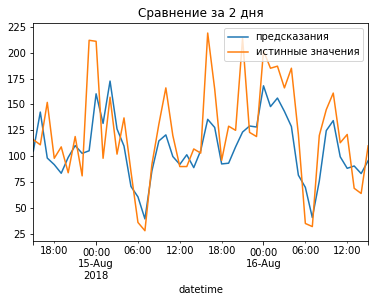

In [41]:
cat_comparing['2018-08-14 15:00:00':'2018-08-16 15:00:00'].plot(title='Сравнение за 2 дня')

<AxesSubplot:title={'center':'Сравнение за 3 дня с ресеймплингом'}, xlabel='datetime'>

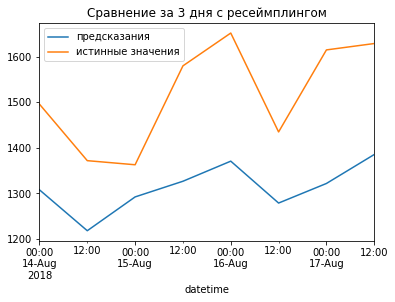

In [52]:
cat_comparing.resample('12H').sum()['2018-08-14':'2018-08-17'].plot(title='Сравнение за 3 дня с ресеймплингом')

Проверка на тестовой выборке для модели случайного леса

In [46]:
dat_forest = make_features(data, 6, 6)

dat_train, dat_test = train_test_split(dat_forest, shuffle=False, test_size=0.2)
        
train_features_forest = dat_train.drop('num_orders', axis=1)
train_target_forest = dat_train['num_orders']
        
test_features_forest = dat_test.drop('num_orders', axis=1)
test_target_forest = dat_test['num_orders']

In [47]:
model = RandomForestRegressor(random_state = 12345, n_estimators=150, max_depth=13)
model.fit(train_features_forest, train_target_forest)
predictions_forest = model.predict(test_features_forest)
forest_score_result = round(rmse(test_target_forest, predictions_forest), 2)
print("Показатель rmse для CatBoostRegressor на тестовой выборке", forest_score_result)

Показатель rmse для CatBoostRegressor на тестовой выборке 46.63


In [48]:
forest_comparing = pd.DataFrame(
    data={'предсказания':predictions_forest,
         'истинные значения':test_target_forest
         }
)
forest_comparing

,предсказания,истинные значения
datetime,,
2018-07-26 06:00:00,65.219534,21
2018-07-26 07:00:00,34.019769,39
2018-07-26 08:00:00,84.497837,80
2018-07-26 09:00:00,105.966036,138
2018-07-26 10:00:00,105.606044,142
...,...,...
2018-08-31 19:00:00,115.369200,136
2018-08-31 20:00:00,109.286126,154
2018-08-31 21:00:00,123.430100,159


<AxesSubplot:title={'center':'Сравнение за 2 дня'}, xlabel='datetime'>

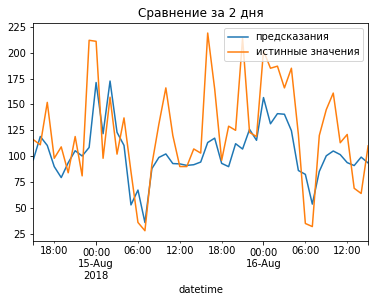

In [49]:
forest_comparing['2018-08-14 15:00:00':'2018-08-16 15:00:00'].plot(title='Сравнение за 2 дня')

<AxesSubplot:title={'center':'Сравнение за 3 дня с ресеймплингом'}, xlabel='datetime'>

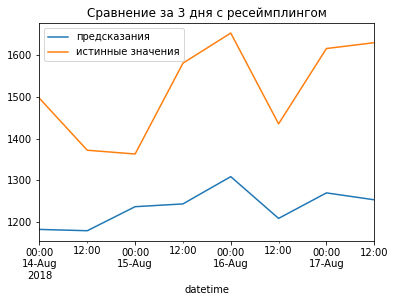

In [55]:
forest_comparing.resample('12H').sum()['2018-08-14':'2018-08-17'].plot(title='Сравнение за 3 дня с ресеймплингом')

С учетом подобранных гиперпараметров и с учетом построения признаков для анализа временных рядов были получены следующие показатели метрики rmse, они приведены в итоговой таблице.

In [51]:
res_dict = {'model':['LinearRegression', 'CatBoostRegressor', 'RandomForestRegressor'],
           'rmse' :[regression_score_result, cat_score_result, forest_score_result]
           }
space = pd.DataFrame(data=res_dict)
space

,model,rmse
0,LinearRegression,52.76
1,CatBoostRegressor,48.42
2,RandomForestRegressor,46.63


Наилучший результат достигнут при помощи модели RandomForestRegressor